In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as tf
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import helper
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset
import glob
import librosa
import math

In [2]:
import IPython.display as ipd

In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [5]:
print(torch.cuda.is_available())

True


In [6]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
xtrain = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

xtest = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
len_train = len(xtrain)
index = list(range(len_train))
size=500

In [8]:
xtr_fi,xtr_li=index[:len_train-size],index[len_train-size:]
xtr_f=torch.utils.data.Subset(xtrain, xtr_fi)
xtr_l=torch.utils.data.Subset(xtrain,xtr_li)

In [9]:
xtr_o=[]
for i,v in xtr_f:
  xtr_o.append([i,0])

In [10]:
len(xtr_o)

49500

In [11]:
transformv = transforms.Compose(
    [
     transforms.Resize(32,32),
     torchvision.transforms.RandomVerticalFlip(p=1),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
vflipped_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transformv)

Files already downloaded and verified


In [12]:
xtr_fi,xtr_li=index[:len_train-size],index[len_train-size:]
xtr_v=torch.utils.data.Subset(vflipped_train, xtr_fi)

In [13]:
xtr_ver=[]
for i,v in xtr_v:
  xtr_ver.append([i,1])

In [14]:
len(xtr_ver)

49500

In [15]:
class rotate90():
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, x):
        a = self.angle
        return tf.rotate(x, a)


In [16]:
rotation_transform=rotate90(90)

In [17]:
transform90 = transforms.Compose(
    [
     transforms.Resize(32,32),
     rotation_transform,
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
rotated_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform90)

Files already downloaded and verified


In [18]:
xtr_fi,xtr_li=index[:len_train-size],index[len_train-size:]
xtr_rt=torch.utils.data.Subset(rotated_train, xtr_fi)

In [19]:
xtr_rot=[]
for i,v in xtr_rt:
  xtr_rot.append([i,2])

In [73]:
o = torch.utils.data.DataLoader(xtr_o, batch_size=2, num_workers=2)
v = torch.utils.data.DataLoader(xtr_ver, batch_size=2, num_workers=2)
r = torch.utils.data.DataLoader(xtr_rot, batch_size=2, num_workers=2)

def print_img(i):
    i = i / 2 + 0.5     
    npi = i.numpy()
    plt.imshow(np.transpose(npi, (1, 2, 0)))
    plt.show()


the original images


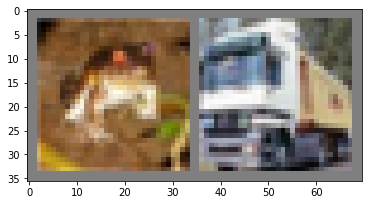

In [74]:

dataiter = iter(o)
img, labe = dataiter.next()
print("the original images")
print_img(torchvision.utils.make_grid(img))

Vertically flipped images


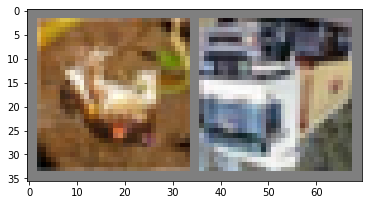

In [75]:

dataiter = iter(v)
img, labe = dataiter.next()
print("Vertically flipped images")
print_img(torchvision.utils.make_grid(img))

90 rotated images


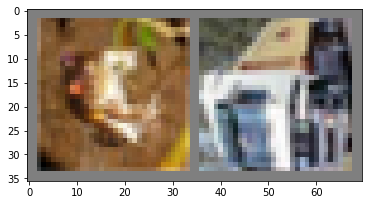

In [76]:

dataiter = iter(r)
img, labe = dataiter.next()
print("90 rotated images")
print_img(torchvision.utils.make_grid(img))

In [20]:
combined_train=torch.utils.data.ConcatDataset((xtr_o,xtr_ver,xtr_rot))

In [21]:
len(combined_train)

148500

In [22]:
batch_num=500

In [23]:
class CNN_prob4p(nn.Module):
  def __init__(self):
    super(CNN_prob4p,self).__init__()
    self.first_conv=nn.Conv2d(3,10,5)
    nn.init.kaiming_normal_(self.first_conv.weight)
    self.relu=nn.ReLU()
    self.pooling=nn.MaxPool2d(2,stride=2)
    self.second_conv=nn.Conv2d(10,10,5)
    nn.init.kaiming_normal_(self.second_conv.weight)
    self.fc1=nn.Linear(10*5*5,20)
    nn.init.kaiming_normal_(self.fc1.weight)
    self.fc2=nn.Linear(20,3)
    nn.init.kaiming_normal_(self.fc2.weight)
  
  def Forward_prop(self,x):
    x1=self.pooling(self.relu(self.first_conv(x)))
    x2=self.pooling(self.relu(self.second_conv(x1)))
    x2=x2.view(-1,10*5*5)
    x3=self.relu(self.fc1(x2))
    out=self.fc2(x3)
    return out

In [24]:
cnn_4p=CNN_prob4p().cuda()

In [26]:
loss=nn.CrossEntropyLoss()
param=cnn_4p.parameters()
optimize=torch.optim.Adam(param,lr=0.001)

In [31]:
combined_train[0][0].shape

torch.Size([3, 32, 32])

In [27]:
train_aug=torch.utils.data.DataLoader(combined_train, batch_size=1024,shuffle=True)
#xte=torch.utils.data.DataLoader(xtest, batch_size=256)

In [28]:
# Training the Feedforward Neural Network
def train_model():
    for num,dat in enumerate(train_aug):

      im,la=dat
      #la=to_torch(la)
      im=im.cuda()
      la=la.cuda()
      ff_out=cnn_4p.Forward_prop(im)
      losses=loss(ff_out,la.cuda())
      optimize.zero_grad()
      losses.backward()
      optimize.step()
   
    #print("epoch {} is done".format(ep))

In [30]:
def accuracy_calculation(no_of_epochs):
  accuracy=[]
  for i in range(no_of_epochs):
    train_model()
    print("epoch {} done".format(i))

In [38]:
acc_pre=accuracy_calculation(100)

epoch 0 done
epoch 1 done
epoch 2 done
epoch 3 done
epoch 4 done
epoch 5 done
epoch 6 done
epoch 7 done
epoch 8 done
epoch 9 done
epoch 10 done
epoch 11 done
epoch 12 done
epoch 13 done
epoch 14 done
epoch 15 done
epoch 16 done
epoch 17 done
epoch 18 done
epoch 19 done
epoch 20 done
epoch 21 done
epoch 22 done
epoch 23 done
epoch 24 done
epoch 25 done
epoch 26 done
epoch 27 done
epoch 28 done
epoch 29 done
epoch 30 done
epoch 31 done
epoch 32 done
epoch 33 done
epoch 34 done
epoch 35 done
epoch 36 done
epoch 37 done
epoch 38 done
epoch 39 done
epoch 40 done
epoch 41 done
epoch 42 done
epoch 43 done
epoch 44 done
epoch 45 done
epoch 46 done
epoch 47 done
epoch 48 done
epoch 49 done
epoch 50 done
epoch 51 done
epoch 52 done
epoch 53 done
epoch 54 done
epoch 55 done
epoch 56 done
epoch 57 done
epoch 58 done
epoch 59 done
epoch 60 done
epoch 61 done
epoch 62 done
epoch 63 done
epoch 64 done
epoch 65 done
epoch 66 done
epoch 67 done
epoch 68 done
epoch 69 done
epoch 70 done
epoch 71 done
ep

In [27]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [40]:
model_save_name = 'pretext.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(cnn_4p.state_dict(), path)

In [31]:
model_save_name = 'pretext.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
cnn_4p.load_state_dict(torch.load(path))

<All keys matched successfully>

In [32]:
class CNN_prob4bas(nn.Module):
  def __init__(self):
    super(CNN_prob4bas,self).__init__()
    self.first_conv=nn.Conv2d(3,10,5)
    nn.init.kaiming_normal_(self.first_conv.weight)
    self.relu=nn.ReLU()
    self.pooling=nn.MaxPool2d(2,stride=2)
    self.second_conv=nn.Conv2d(10,10,5)
    nn.init.kaiming_normal_(self.second_conv.weight)
    self.fc1=nn.Linear(10*5*5,20)
    nn.init.kaiming_normal_(self.fc1.weight)
    self.fc2=nn.Linear(20,10)
    nn.init.kaiming_normal_(self.fc2.weight)
  
  def Forward_prop(self,x):
    x1=self.pooling(self.relu(self.first_conv(x)))
    x2=self.pooling(self.relu(self.second_conv(x1)))
    x2=x2.view(-1,10*5*5)
    x3=self.relu(self.fc1(x2))
    out=self.fc2(x3)
    return out

In [33]:
cnn_4bas=CNN_prob4bas().cuda()

In [35]:
loss=nn.CrossEntropyLoss()
param=cnn_4bas.parameters()
optimize=torch.optim.Adam(param,lr=0.001)

In [36]:
train_bas=torch.utils.data.DataLoader(xtr_l, batch_size=500)
test_bas=torch.utils.data.DataLoader(xtest, batch_size=500)

In [37]:
# Training the Feedforward Neural Network
def train_model():
    for num,dat in enumerate(train_bas):

      im,la=dat
      #la=to_torch(la)
      im=im.cuda()
      la=la.cuda()
      ff_out=cnn_4bas.Forward_prop(im)
      losses=loss(ff_out,la)
      optimize.zero_grad()
      losses.backward()
      optimize.step()
   
    #print("epoch {} is done".format(ep))

In [38]:
# Testing the Feedforward Neural Network

def validation():
  correct_count=0
  with torch.no_grad():
    for dat in test_bas:
      im,la=dat
      test_out=cnn_4bas.Forward_prop(im.cuda())
      _,pred=torch.max(test_out.data,1)
      correct_count+=(pred.cpu()==la).sum().item()
  return correct_count/10000

In [39]:
def accuracy_calculation(no_of_epochs):
  accuracy=[]
  for i in range(no_of_epochs):
    train_model()
    va=validation()
    accuracy.append(va)
    if(i%100==0):
      print("epoch {} is done and accuracy is {}".format(i,va))
  return accuracy

In [40]:
acc_base=accuracy_calculation(10000)

epoch 0 is done and accuracy is 0.0879
epoch 100 is done and accuracy is 0.2665
epoch 200 is done and accuracy is 0.296
epoch 300 is done and accuracy is 0.2995
epoch 400 is done and accuracy is 0.2996
epoch 500 is done and accuracy is 0.2995
epoch 600 is done and accuracy is 0.2986
epoch 700 is done and accuracy is 0.2984
epoch 800 is done and accuracy is 0.2992
epoch 900 is done and accuracy is 0.2992
epoch 1000 is done and accuracy is 0.2995
epoch 1100 is done and accuracy is 0.299
epoch 1200 is done and accuracy is 0.2995
epoch 1300 is done and accuracy is 0.299
epoch 1400 is done and accuracy is 0.299
epoch 1500 is done and accuracy is 0.2987
epoch 1600 is done and accuracy is 0.299
epoch 1700 is done and accuracy is 0.2995
epoch 1800 is done and accuracy is 0.2999
epoch 1900 is done and accuracy is 0.3
epoch 2000 is done and accuracy is 0.3004
epoch 2100 is done and accuracy is 0.3004
epoch 2200 is done and accuracy is 0.2999
epoch 2300 is done and accuracy is 0.3002
epoch 2400 i

Text(0, 0.5, 'Validation Accuracy')

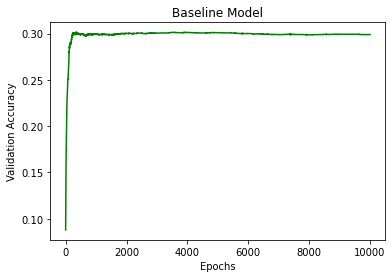

In [41]:
plt.plot(list(range(10000)),acc_base,'g')
plt.title('Baseline Model')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

In [42]:
import pickle

In [43]:
with open('acc_base.pkl', 'wb') as f:
  pickle.dump(acc_base, f)

In [44]:
with open('acc_base.pkl', 'rb') as f:
  acc_base = pickle.load(f)

In [ ]:
drive.mount('/content/gdrive')

In [ ]:
model_save_name = 'baseline4.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(cnn_4bas.state_dict(), path)

In [ ]:
model_save_name = 'baseline4.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
cnn_4bas.load_state_dict(torch.load(path))

In [ ]:
cnn_4bas.fc1.weight

In [58]:
class CNN_prob4sup(nn.Module):
  def __init__(self):
    super(CNN_prob4sup,self).__init__()
    self.first_conv=nn.Conv2d(3,10,5)
    #self.first_conv.weight.data.copy_(cnn_4p.first_conv.weight.data)
    self.relu=nn.ReLU()
    self.pooling=nn.MaxPool2d(2,stride=2)
    self.second_conv=nn.Conv2d(10,10,5)
    #self.second_conv.weight.data.copy_(cnn_4p.second_conv.weight.data)
    self.fc1=nn.Linear(10*5*5,20)
    self.fc1.weight.data.copy_(cnn_4p.fc1.weight.data)
    self.fc2=nn.Linear(20,10)
    #nn.init.kaiming_normal_(self.fc2.weight)
  
  def Forward_prop(self,x):
    x1=self.pooling(self.relu(self.first_conv(x)))
    x2=self.pooling(self.relu(self.second_conv(x1)))
    x2=x2.view(-1,10*5*5)
    x3=self.relu(self.fc1(x2))
    out=self.fc2(x3)
    return out

In [59]:
mo=cnn_4p.state_dict()
mo['fc2.weight']=torch.nn.init.kaiming_normal_(torch.empty(10,20))
mo['fc2.bias']=torch.nn.init.zeros_(torch.empty(10))


In [60]:
cnn_4sup=CNN_prob4sup().cuda()

In [61]:
cnn_4sup.load_state_dict(mo)

<All keys matched successfully>

In [62]:
loss=nn.CrossEntropyLoss()

param=cnn_4sup.parameters()
optimize=torch.optim.Adam([{'params': [param for name, param in cnn_4sup.named_parameters() if 'fc2' not in name]}, {'params': cnn_4sup.fc2.parameters(), 'lr': 0.001}], lr=0.00001)

In [63]:
# Training the Feedforward Neural Network
def train_model():
    for num,dat in enumerate(train_bas):

      im,la=dat
      #la=to_torch(la)
      im=im.cuda()
      la=la.cuda()
      ff_out=cnn_4sup.Forward_prop(im)
      losses=loss(ff_out,la)
      optimize.zero_grad()
      losses.backward()
      optimize.step()
   
    #print("epoch {} is done".format(ep))

In [64]:
# Testing the Feedforward Neural Network

def validation():
  length=0
  correct_count=0
  with torch.no_grad():
    for dat in test_bas:
      im,la=dat
      test_out=cnn_4sup.Forward_prop(im.cuda())
      _,pred=torch.max(test_out.data,1)
      length+=la.size(0)
      correct_count+=(pred.cpu()==la).sum().item()
  return correct_count/10000

In [65]:
def accuracy_calculation(no_of_epochs):
  accuracy=[]
  for i in range(no_of_epochs):
    train_model()
    va=validation()
    accuracy.append(va)
    if(i%100==0):
      print("epoch {} is done and accuracy is {}".format(i,va))
  return accuracy

In [66]:
acc_sup=accuracy_calculation(10000)

epoch 0 is done and accuracy is 0.0911
epoch 100 is done and accuracy is 0.1453
epoch 200 is done and accuracy is 0.1979
epoch 300 is done and accuracy is 0.2518
epoch 400 is done and accuracy is 0.288
epoch 500 is done and accuracy is 0.3072
epoch 600 is done and accuracy is 0.3205
epoch 700 is done and accuracy is 0.3302
epoch 800 is done and accuracy is 0.3367
epoch 900 is done and accuracy is 0.3439
epoch 1000 is done and accuracy is 0.3485
epoch 1100 is done and accuracy is 0.3541
epoch 1200 is done and accuracy is 0.357
epoch 1300 is done and accuracy is 0.3578
epoch 1400 is done and accuracy is 0.3591
epoch 1500 is done and accuracy is 0.3592
epoch 1600 is done and accuracy is 0.3609
epoch 1700 is done and accuracy is 0.3599
epoch 1800 is done and accuracy is 0.3596
epoch 1900 is done and accuracy is 0.3586
epoch 2000 is done and accuracy is 0.3588
epoch 2100 is done and accuracy is 0.3594
epoch 2200 is done and accuracy is 0.3592
epoch 2300 is done and accuracy is 0.3585
epoch 

Text(0, 0.5, 'Validation Accuracy')

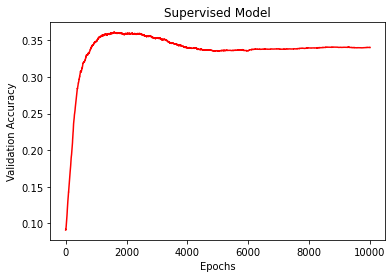

In [68]:
plt.plot(list(range(10000)),acc_sup,'r')
plt.title('Supervised Model')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

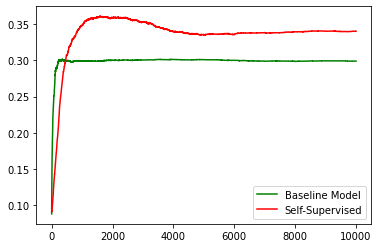

In [70]:
plt.plot(list(range(10000)),acc_base,'g')
plt.plot(list(range(10000)),acc_sup,'r')
plt.legend(['Baseline Model','Self-Supervised'])
plt.show()

In [71]:
with open('acc_sup.pkl', 'wb') as f:
  pickle.dump(acc_sup, f)

In [72]:
with open('acc_sup.pkl', 'wb') as f:
  pickle.dump(acc_sup, f)